In [1]:
import os
import sys
dir_path = os.getcwd()
print("The directory of this script is:", dir_path)
root_path = os.path.dirname(dir_path)
sys.path.append(root_path)
print("The root directory is:", root_path)

The directory of this script is: c:\Users\HP\Desktop\Projects\Subscription-Churn-Prediction\notebooks
The root directory is: c:\Users\HP\Desktop\Projects\Subscription-Churn-Prediction


In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv(f"{root_path}\data\Telco-Customer-Churn.csv")
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce").fillna(0).astype(float)
data['gender'] = data['gender'].map({'Male': 1, 'Female': 0})
data['Contract'] = data['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})

n_bins = 5
for col in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    data[f'{col}_bin'] = pd.qcut(data[col], q=n_bins, labels=False, duplicates='drop')
for col in data.columns:
    if col == 'Churn':
        continue
    unique_vals = data[col].dropna().unique()
    if set(unique_vals) <= {'Yes', 'No'}:
        data[col] = data[col].map({'No': 0, 'Yes': 1})

for col in data.columns:
    if col == 'Churn':
        continue
    unique_vals = data[col].dropna().unique()
    if 'No phone service' in unique_vals or 'No internet service' in unique_vals:
        mapping = {'No phone service': -1, 'No internet service': -1, 'No': 0, 'Yes': 1}
        data[col] = data[col].map(mapping)

data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_bin,MonthlyCharges_bin,TotalCharges_bin
0,7590-VHVEG,0,0,1,0,1,0,-1,DSL,0,...,0,0,1,Electronic check,29.85,29.85,No,0,1,0
1,5575-GNVDE,1,0,0,0,34,1,0,DSL,1,...,0,1,0,Mailed check,56.95,1889.50,No,2,1,2
2,3668-QPYBK,1,0,0,0,2,1,0,DSL,1,...,0,0,1,Mailed check,53.85,108.15,Yes,0,1,0
3,7795-CFOCW,1,0,0,0,45,0,-1,DSL,1,...,0,1,0,Bank transfer (automatic),42.30,1840.75,No,3,1,2
4,9237-HQITU,0,0,0,0,2,1,0,Fiber optic,0,...,0,0,1,Electronic check,70.70,151.65,Yes,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,1,0,1,1,24,1,1,DSL,1,...,1,1,1,Mailed check,84.80,1990.50,No,2,3,2
7039,2234-XADUH,0,0,1,1,72,1,1,Fiber optic,0,...,1,1,1,Credit card (automatic),103.20,7362.90,No,4,4,4
7040,4801-JZAZL,0,0,1,1,11,0,-1,DSL,1,...,0,0,1,Electronic check,29.60,346.45,No,1,1,1
7041,8361-LTMKD,1,1,1,0,4,1,1,Fiber optic,0,...,0,0,1,Mailed check,74.40,306.60,Yes,0,2,1


In [3]:
for col in data.columns:
    if col == "customerID":
        continue
    print(data[col].value_counts(dropna=False, normalize=True))
    print("-"*40)

gender
1    0.504756
0    0.495244
Name: proportion, dtype: float64
----------------------------------------
SeniorCitizen
0    0.837853
1    0.162147
Name: proportion, dtype: float64
----------------------------------------
Partner
0    0.516967
1    0.483033
Name: proportion, dtype: float64
----------------------------------------
Dependents
0    0.700412
1    0.299588
Name: proportion, dtype: float64
----------------------------------------
tenure
1     0.087037
72    0.051399
2     0.033792
3     0.028397
4     0.024989
        ...   
28    0.008093
39    0.007951
44    0.007241
36    0.007099
0     0.001562
Name: proportion, Length: 73, dtype: float64
----------------------------------------
PhoneService
1    0.903166
0    0.096834
Name: proportion, dtype: float64
----------------------------------------
MultipleLines
 0    0.481329
 1    0.421837
-1    0.096834
Name: proportion, dtype: float64
----------------------------------------
InternetService
Fiber optic    0.439585
DSL   

In [4]:
import scipy.stats as ss
def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical association."""
    conf_matrix = pd.crosstab(x, y)
    
    if conf_matrix.shape[0] == 1 or conf_matrix.shape[1] == 1:
        return np.nan  # one variable is constant
    
    chi2 = ss.chi2_contingency(conf_matrix, correction=True)[0]
    n = conf_matrix.to_numpy().sum()
    phi2 = chi2 / n
    r, k = conf_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min(kcorr-1, rcorr-1))


In [5]:
# Identify categorical columns (object or category dtype)
cat_cols = data.columns.tolist()

# Remove 'Churn' itself from the list so we don't compare it to itself
cat_cols = [col for col in cat_cols if col != 'Churn']

# Calculate Cramér's V for each categorical column vs 'Churn'
cramer_vs_churn = {}
for col in cat_cols:
    cramer_vs_churn[col] = cramers_v(data[col], data['Churn'])

# Convert to a pandas Series for better display
cramer_vs_churn = pd.Series(cramer_vs_churn).sort_values(ascending=False)
print(cramer_vs_churn)

Contract              0.409798
tenure                0.375575
tenure_bin            0.365772
OnlineSecurity        0.347016
TechSupport           0.342526
InternetService       0.322037
PaymentMethod         0.302677
OnlineBackup          0.291850
DeviceProtection      0.281095
MonthlyCharges        0.276759
TotalCharges_bin      0.241646
StreamingMovies       0.230351
StreamingTV           0.229902
MonthlyCharges_bin    0.213128
PaperlessBilling      0.191141
Dependents            0.163448
SeniorCitizen         0.149991
Partner               0.149663
MultipleLines         0.036400
PhoneService          0.000000
TotalCharges          0.000000
gender                0.000000
customerID                 NaN
dtype: float64


C:\Users\HP\AppData\Local\Temp\ipykernel_29676\2608845624.py:17: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min(kcorr-1, rcorr-1))


In [6]:
X = data.drop(["Churn","customerID", 'tenure', 'MonthlyCharges', 'TotalCharges'], axis=1)
X = pd.get_dummies(X, drop_first=True)
y = data["Churn"]


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8, stratify=y
)
class_weight={ 'No': 1, 'Yes': 5 }
clf = DecisionTreeClassifier(splitter="best" , max_depth=20, criterion='gini',min_samples_split=80, min_samples_leaf=10, class_weight=class_weight)
clf.fit(X_train, y_train)
for name, features_set, labels_set in [('Train', X_train, y_train), ('Test', X_test, y_test)]:
    print("-"*40)
    y_predicted = clf.predict(features_set)
    acc = accuracy_score(labels_set, y_predicted)
    prec = precision_score(labels_set, y_predicted, pos_label="Yes")
    rec = recall_score(labels_set, y_predicted, pos_label="Yes")
    fbeta = fbeta_score(labels_set, y_predicted, beta=2, pos_label="Yes")
    print(f"{name} - Accuracy: {acc:.2f} - Precision: {prec:.2f} - Recall: {rec:.2f} - F2: {fbeta:.2f}")

print("-"*40)
print("Tree depth:", clf.get_depth())
print("Number of leaves:", clf.get_n_leaves())
print("Total nodes:", clf.tree_.node_count)

----------------------------------------
Train - Accuracy: 0.72 - Precision: 0.49 - Recall: 0.90 - F2: 0.77
----------------------------------------
Test - Accuracy: 0.70 - Precision: 0.46 - Recall: 0.84 - F2: 0.72
----------------------------------------
Tree depth: 7
Number of leaves: 28
Total nodes: 55


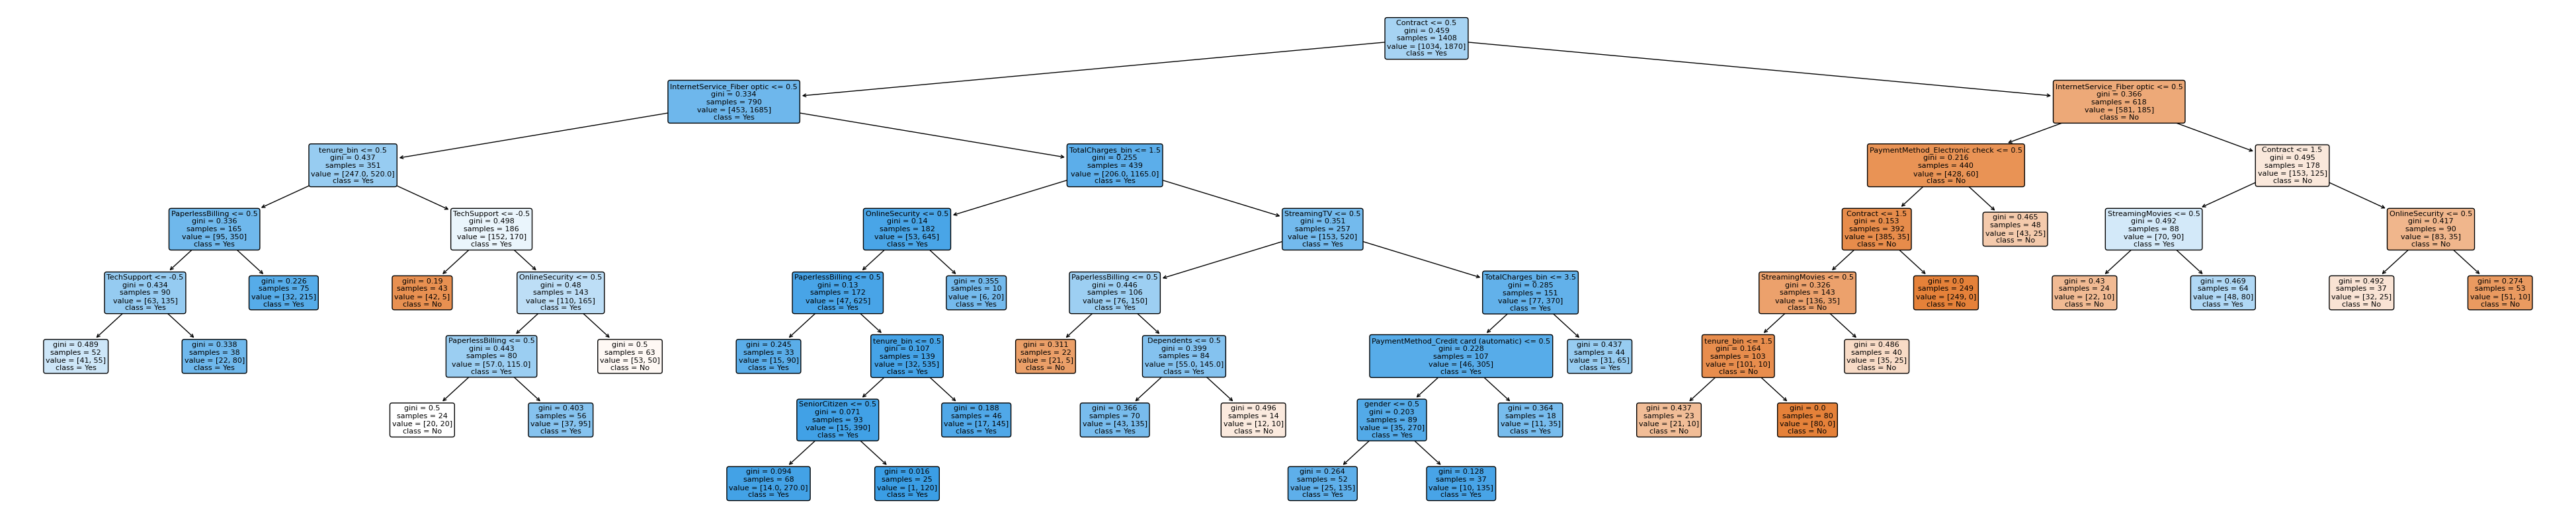

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50,10))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=[str(c) for c in clf.classes_],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.show()